## Classify spam vs no spam emails using BERT pretrained
* 1. We will handle imbalanced datasets
* 2. Preprocessing the datasets
* 3. Load BERT model and get embeding vectors for few sample statements
* 4. Build Model train and evaluate

credit: https://www.kaggle.com/datasets/venky73/spam-mails-dataset

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

#### 15% spam, 85% ham emails: Easy to see imbalanced datasets

In [7]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [11]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [12]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3750,spam,Dear Voucher Holder 2 claim your 1st class air...,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1
2312,spam,Congratulations! Thanks to a good friend U hav...,1
3476,ham,"Night has ended for another day, morning has c...",0
5524,spam,You are awarded a SiPix Digital Camera! call 0...,1


### Split dataset into train and test

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [14]:
X_train.head(4)

5280                  Vikky, come around  &lt;TIME&gt; ..
2555                      I'll reach in ard 20 mins ok...
1207    As a SIM subscriber, you are selected to recei...
1427                                                Ok...
Name: Message, dtype: object

## Import BERT model and get embeding vectors for few sample statements

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [19]:
get_sentence_embeding([
    '''I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.'''  
]).shape

TensorShape([1, 768])

### Build model

In [20]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [23]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 192s 5s/step - loss: 0.6745 - accuracy: 0.5732 - precision: 0.5740 - recall: 0.5679
Epoch 2/10
35/35 [==============================] - 195s 6s/step - loss: 0.5382 - accuracy: 0.7848 - precision: 0.7948 - recall: 0.7679
Epoch 3/10
35/35 [==============================] - 183s 5s/step - loss: 0.4507 - accuracy: 0.8643 - precision: 0.8411 - recall: 0.8982
Epoch 4/10
35/35 [==============================] - 211s 6s/step - loss: 0.4042 - accuracy: 0.8643 - precision: 0.8505 - recall: 0.8839
Epoch 5/10
35/35 [==============================] - 181s 5s/step - loss: 0.3693 - accuracy: 0.8821 - precision: 0.8715 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 178s 5s/step - loss: 0.3504 - accuracy: 0.8679 - precision: 0.8601 - recall: 0.8786
Epoch 7/10
35/35 [==============================] - 183s 5s/step - loss: 0.3380 - accuracy: 0.8777 - precision: 0.8717 - recall: 0.8857
Epoch 8/10
35/35 [==============================

In [24]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 62s 5s/step - loss: 0.2840 - accuracy: 0.9198 - precision: 0.9435 - recall: 0.8930


[0.2840438187122345, 0.9197860956192017, 0.9435028433799744, 0.893048107624054]

In [25]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 63s 5s/step


In [27]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[177,  10],
       [ 20, 167]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

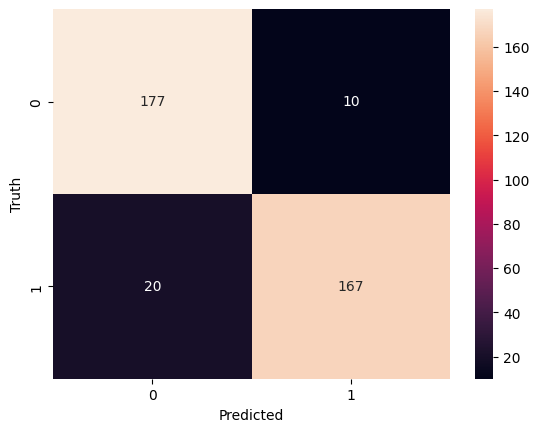

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Inference

In [30]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 4s 4s/step


array([[0.6435022 ],
       [0.711475  ],
       [0.64566356],
       [0.13416155],
       [0.05736903]], dtype=float32)